## Data extraction from sqllite

In [43]:
import sqlite3
connection =  sqlite3.connect("dfa_ml_4.sqlite")
cur = connection.cursor()

#### Necessary classification code target

In [ ]:
# ### Classification codes #####
# GENERIC_ARCING 						= 23100, 
# GENERIC_LONG_ARCING					= 23104, 
# GENERIC_SHORT_ARCING 				= 23102,
# CAPACITOR_ON 						= 10110, 
# CAPACITOR_OFF 						= 10120, 
# CAPACITOR_ON_ABNORMAL 				= 20110, 
# CAPACITOR_RESTRIKE 					= 20210,
# CAPACITOR_RESTRIKE_SEVERE			= 20211, 
# CAPACITOR_ON_UNBALANCED				= 20130,
# CAPACITOR_BOUNCE					= 20310, 
# CAPACITOR_OFF_UNBALANCED 			= 20140, 
# CAPACITOR_ON_VAR_IMBALANCE 			= 20510,
# CAPACITOR_OFF_VAR_IMBALANCE			= 20520,
# ARCING_INSIDE_CAPACITOR				= 23180,
# UNKNOWN_ABNORMAL					= 28110,
# CT_PT_SWITCH_CLOSED					= 30200,
# CT_PT_SWITCH_OPENED 				= 30100,
# OC_NORMAL							= 15110,
# OC_CAPACITOR						= 20410,
# OC_LESS_THAN_1_CYC					= 15220,
# REVERSE_FAULT						= 15710,
# INRUSH								= 13170,
# BREAKER_CLOSE						= 13171,
# LOAD_STEP_UP						= 13120,
# LOAD_STEP_DOWN						= 13121,
# MOTOR_START							= 12110,
# SERIES_SWITCH_ARCING				= 23190,
# VOLTAGE_STEP_UP						= 13210,
# VOLTAGE_STEP_DOWN					= 13220,
# LOAD_VARIATION						= 13110,
# VOLTAGE_HF_TRANSIENT				= 13310,
# CURRENT_HF_TRANSIENT				= 23310,

###

In [1]:
import pandas as pd

# extracting for capcitor on code "10110"}
df = pd.read_sql_query("SELECT count(*) from dfa_ml_data_records  ", connection)

# Verify that result of SQL query is stored in the dataframe
print(df.head())

NameError: name 'connection' is not defined

In [ ]:
176 zeros


In [44]:
# Bulk extract
clause = ""
file_name = "main"
limit=1000
sql_fetch_blob_query_1 = """SELECT id, monitor_id, waveform_id, file_name, classification_code, position_code, phase_code, ground_code, powerline_frequency, duration_seconds, rms_data  
                            from """ + file_name + """.dfa_ml_data_records,
                            (select  max(waveform_id) as wav, max(monitor_id) as mon from
                            (select waveform_id, monitor_id, classification_code, position_code FROM dfa_ml_data_records where monitor_id  NOT IN (110003001002, 100001001001, 100002001001, 100002002001, 100002002002, 101001001001, 101002001001, 101002001002, 101002001003, 110002001002) and monitor_id > 100000000000 and monitor_id NOT IN (110001001001) and duration_seconds >9 and duration_seconds < 30)
                            group  by waveform_id, monitor_id
                            having count(waveform_id) = 1 """ + \
                            clause + ") as der " + \
                           "where waveform_id = wav and monitor_id = mon and classification_code =='23310' limit " +\
                            str(limit)

In [45]:
import time
start = time.time()
records1=cur.execute(sql_fetch_blob_query_1)
end = time.time()
print(end - start)

1.5505290031433105


In [46]:
## Required data
newrcd = records1.fetchall()

In [42]:
len(newrcd)

799

### Plotting and normalization

In [47]:
import numpy as np
import shutil
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import time
from enum import IntEnum

In [48]:
class Indx(IntEnum):
    ID = 0
    MONITOR = 1
    RECORD = 2
    FILE = 3
    CLASS = 4
    POSITION = 5
    PHASE = 6
    GROUND = 7
    FREQ = 8
    SECONDS = 9
    BLOB = 10
class SIndx(IntEnum):
    ID = 0
    NAME = 1
    PT_S_A = 2
    PT_S_B = 3
    PT_S_C = 4
    PT_P_A = 5
    PT_P_B = 6
    PT_P_C = 7
    CT_S_A = 8
    CT_S_B = 9
    CT_S_C = 10
    CT_P_A = 11
    CT_P_B = 12
    CT_P_C = 13
    VA_SCALE = 14
    VB_SCALE = 15
    VC_SCALE = 16
    IA_SCALE = 17
    IB_SCALE = 18
    IC_SCALE = 19
    PQ_SCALE = 99
    NO_SCALE = 100
class Channels(IntEnum):
    VA    =    0
    VB    =    1
    VC    =    2
    IA    =    3
    IB    =    4
    IC    =    5
    IN    =    6
    VA_PD =    7
    VB_PD =    8
    VC_PD =    9
    IA_PD =    10
    IB_PD =    11
    IC_PD =    12
    IN_PD =    13
    PA =       14
    PB =       15
    PC =       16
    QA =       17
    QB =       18
    QC =       19
    VA_SD =    20
    VB_SD =    21
    VC_SD =    22
    IA_SD =    23
    IB_SD =    24
    IC_SD =    25
    IN_SD =    26
    VA_EVENS = 27
    VB_EVENS = 28
    VC_EVENS = 29
    IA_EVENS = 30
    IB_EVENS = 31
    IC_EVENS = 32
    IN_EVENS = 33
    VA_ODDS =  34
    VB_ODDS =  35
    VC_ODDS =  36
    IA_ODDS =  37
    IB_ODDS =  38
    IC_ODDS =  39
    IN_ODDS =  40

In [720]:
Channels.VB

<Channels.VB: 1>

In [244]:
# def get_scale_lookup(filename = 'dfa_ml_scaling.csv'):
#     scale_look_up = dict((rows[0], rows) for rows in [tuple(x) for x in pd.read_csv(filename, delimiter=',').values])
#     return scale_look_up
# # function call
# scale_look_up = get_scale_lookup()

In [49]:
# raw vector
def get_raw_vector_bulk(records_in, record_indx, channel, scale_indx):
    arr = np.frombuffer(records_in[record_indx][-1], dtype=np.float32)
    len = records_in[record_indx][Indx.SECONDS] * records_in[record_indx][Indx.FREQ]
    vect = arr[(len*channel):(len*(channel + 1))][:500]
    pos_code = records_in[record_indx][5]
    phase_code = records_in[record_indx][6]
    return vect,pos_code,phase_code

In [52]:
# for one channel
vect=get_raw_vector_bulk(newrcd,0,Channels.VA,SIndx.VA_SCALE)
# print(vect)
print(vect.shape)

AttributeError: 'tuple' object has no attribute 'shape'

## All channel input

In [57]:
new_result = dict()
# rms_vecs = []
a = [x for x in range (0,1)]
b = ['VA','VB','VC',
     'IA','IB','IC',
     'VA_PD','VB_PD','VC_PD',
     'IA_PD','IB_PD','IC_PD',
     
     'VA_SD','VB_SD','VC_SD',
     'IA_SD','IB_SD','IC_SD',
     'VA_EVENS','VB_EVENS','VC_EVENS',
     'IA_EVENS','IB_EVENS','IC_EVENS',
     'VA_ODDS','VB_ODDS','VC_ODDS',
     'IA_ODDS','IB_ODDS','IC_ODDS',
     'PA','PB','PC',
     'QA','QB','QC'      
    ]
for i in a:
    rms_raw_vecs = []
    for j in b:
        
        if j == 'VA':
            channel=Channels.VA
            scale_indx = SIndx.VA_SCALE
        elif j == 'VB':
            channel=Channels.VB
            scale_indx = SIndx.VB_SCALE
        elif j == 'VC':
            channel=Channels.VC
            scale_indx = SIndx.VC_SCALE
        elif j == 'IA':
            channel=Channels.IA
            scale_indx = SIndx.IA_SCALE
        elif j == 'IB':
            channel=Channels.IB
            scale_indx = SIndx.IB_SCALE
        elif j == 'IC':
            channel=Channels.IC
            scale_indx = SIndx.IC_SCALE
        elif j == 'VA_PD':
            channel=Channels.VA_PD
            scale_indx = SIndx.VA_SCALE
        elif j == 'VB_PD':
            channel=Channels.VB_PD
            scale_indx = SIndx.VB_SCALE
        elif j == 'VC_PD':
            channel=Channels.VC_PD
            scale_indx = SIndx.VC_SCALE
        elif j == 'IA_PD':
            channel=Channels.IA_PD
            scale_indx = SIndx.IA_SCALE
        elif j == 'IB_PD':
            channel=Channels.IB_PD
            scale_indx = SIndx.IB_SCALE
        elif j == 'IC_PD':
            channel=Channels.IC_PD
            scale_indx = SIndx.IC_SCALE
        elif j == 'VA_SD':
            channel=Channels.VA_SD
            scale_indx = SIndx.VA_SCALE
        elif j == 'VB_SD':
            channel=Channels.VB_SD
            scale_indx = SIndx.VB_SCALE
        elif j == 'VC_SD':
            channel=Channels.VC_SD
            scale_indx = SIndx.VC_SCALE 
        elif j == 'IA_SD':
            channel=Channels.IA_SD
            scale_indx = SIndx.IA_SCALE
        elif j == 'IB_SD':
            channel=Channels.IB_SD
            scale_indx = SIndx.IB_SCALE
        elif j == 'IC_SD':
            channel=Channels.IC_SD
            scale_indx = SIndx.IC_SCALE
        elif j == 'VA_EVENS':
            channel=Channels.VA_EVENS
            scale_indx = SIndx.VA_SCALE
        elif j == 'VB_EVENS':
            channel=Channels.VB_EVENS
            scale_indx = SIndx.VB_SCALE
        elif j == 'VC_EVENS':
            channel=Channels.VC_EVENS
            scale_indx = SIndx.VC_SCALE 
        elif j == 'IA_EVENS':
            channel=Channels.IA_EVENS
            scale_indx = SIndx.IA_SCALE
        elif j == 'IB_EVENS':
            channel=Channels.IB_EVENS
            scale_indx = SIndx.IB_SCALE
        elif j == 'IC_EVENS':
            channel=Channels.IC_EVENS
            scale_indx = SIndx.IC_SCALE
        elif j == 'VA_ODDS':
            channel=Channels.VA_ODDS
            scale_indx = SIndx.VA_SCALE
        elif j == 'VB_ODDS':
            channel=Channels.VB_ODDS
            scale_indx = SIndx.VB_SCALE
        elif j == 'VC_ODDS':
            channel=Channels.VC_ODDS
            scale_indx = SIndx.VC_SCALE 
        elif j == 'IA_ODDS':
            channel=Channels.IA_ODDS
            scale_indx = SIndx.IA_SCALE
        elif j == 'IB_ODDS':
            channel=Channels.IB_ODDS
            scale_indx = SIndx.IB_SCALE
        elif j == 'IC_ODDS':
            channel=Channels.IC_ODDS
            scale_indx = SIndx.IC_SCALE
        elif j =='PA':
            channel=Channels.PA
            scale_indx = SIndx.VA_SCALE
        elif j =='PB':
            channel=Channels.PA
            scale_indx = SIndx.VB_SCALE
        elif j =='PC':
            channel=Channels.PA
            scale_indx = SIndx.VC_SCALE
            
        elif j =='QA':
            channel=Channels.QA
            scale_indx = SIndx.IA_SCALE
        elif j =='QB':
            channel=Channels.QA
            scale_indx = SIndx.IB_SCALE
        elif j =='QC':
            channel=Channels.QA
            scale_indx = SIndx.IC_SCALE
            
#         print(i)
#         print(j)
#         print(channel)
#         print(scale_indx)
                  
        vect,pos_code,phase_code= get_raw_vector_bulk(records_in = newrcd, record_indx = i, channel=channel, scale_indx = scale_indx)
#        #int push
        rms_raw_vecs.append(vect.astype(int))
    rms_raw_vecs.append(pos_code)
    rms_raw_vecs.append(phase_code)
    new_result[i] = rms_raw_vecs
        
new_result        

{0: [array([14879, 14879, 14880, 14880, 14880, 14880, 14880, 14880, 14880,
         14880, 14880, 14880, 14879, 14879, 14879, 14879, 14879, 14879,
         14879, 14879, 14879, 14879, 14879, 14879, 14880, 14880, 14880,
         14880, 14880, 14880, 14880, 14880, 14881, 14881, 14881, 14881,
         14881, 14881, 14881, 14881, 14882, 14882, 14882, 14882, 14882,
         14882, 14882, 14882, 14882, 14882, 14882, 14882, 14883, 14883,
         14884, 14884, 14884, 14885, 14885, 14885, 14885, 14885, 14886,
         14886, 14886, 14886, 14886, 14886, 14887, 14887, 14887, 14887,
         14887, 14887, 14888, 14888, 14887, 14887, 14886, 14886, 14885,
         14885, 14885, 14886, 14886, 14886, 14886, 14886, 14886, 14886,
         14886, 14885, 14885, 14885, 14885, 14885, 14885, 14884, 14884,
         14884, 14884, 14884, 14883, 14882, 14882, 14882, 14882, 14882,
         14882, 14882, 14882, 14883, 14883, 14884, 14884, 14884, 14883,
         14883, 14883, 14883, 14882, 14886, 14883, 14884, 148

In [55]:
new_result[0][36]

0

In [626]:
# normalization V1
### Normalization Logic

# v_max = max([VA, VB, VC])
# v_min =  min([VA, VB, VC])
# va_norm =  (va - v_min)/(v_max - vmin)
# vb_norm =  (vb - v_min)/(v_max - vmin)
# vc_norm =  (vc - v_min)/(v_max - vmin)
# va_pd_norm = va_pd/v_max
# vb_pd_norm = vb_pd/v_max
# vc_pd_norm = vc_pd/v_max

####
# groups for max min calculation

# Gruoup-1
# [VA,VB,VC]

# Gruoup-2
# [IA,IB,IC]

# Gruoup-3
# [VA_PD,VB_PD,VC_PD,VA_SD,VB_SD,VC_SD]

# Group-4
# [IA_PD,IB_PD,IC_PD,IA_SD,IB_SD,IC_SD]

# Group-5
# pq_range = max(pabc_max - pabc_min, qabc_max - qabc_min)
# [PA,PB,PC-#range max(range) for PA,PB,PC find the min separtely,
#           #devide by max range during norm
# QA,QB,QC] # same as above

# Group-6
# [VA_EVENS,VB_EVENS,VC_EVENS]# VA(EVEN) AND ODD shares same max not min mostly zero but need to check
# [VA_ODDS,VB_ODDS,VC_ODDS]

# Group-7
# [IA_EVENS,IB_EVENS,IC_EVENS]#IA(EVEN) AND ODD shares the max same as VA even odd  min need to check
# [IA_ODDS,IB_ODDS,IC_ODDS]

Norm_arr = (vect - np.min(vect))/(np.max(vect)- np.min(vect))
# Norm_arr

In [66]:
#va
_all = new_result[0]
# for end
# for i in _all:
#     np.pad(i,(0,72))
vabc_all = np.dstack((_all[0],_all[1],_all[2]))
vabc_max = np.max(vabc_all)
vabc_min = np.min(vabc_all)
#VA VB VC
# norm_vabc = (vabc_all-vabc_min)/(vabc_max-vabc_min)

iabc_all = np.dstack((_all[3],_all[4],_all[5]))
iabc_max = np.max(iabc_all)
iabc_min = np.min(iabc_all)
#IA IB IC
# norm_iabc = (iabc_all-iabc_min)/(iabc_max-iabc_min)

PD_SD_vabc_all =  np.dstack((_all[6],_all[7],_all[8],_all[12],_all[13],_all[14]))
PD_SD_vabc_max = np.max(vabc_max)
PD_SD_vabc_min = np.min(PD_SD_vabc_all)
#VA_SD VB_SD VC_SD VA_PD VB_PD VC_PD
# norm_PD_SD_vabc = (PD_SD_vabc_all-PD_SD_vabc_min)/(PD_SD_vabc_max-PD_SD_vabc_min)

PD_SD_iabc_all = np.dstack((_all[9],_all[10],_all[11],_all[15],_all[16],_all[17]))
PD_SD_iabc_max = np.max(iabc_max)
PD_SD_iabc_min = np.min(PD_SD_iabc_all)
#VA_SD VB_SD VC_SD VA_PD VB_PD VC_PD
# norm_PD_SD_iabc = (PD_SD_iabc_all-PD_SD_iabc_min)/(PD_SD_iabc_max-PD_SD_iabc_min)

vabc_even_odd_all = np.dstack((_all[18],_all[19],_all[20],_all[24],_all[25],_all[26]))
vabc_even_odd_max = np.max(vabc_even_odd_all)
vabc_even_odd_min = np.min(vabc_even_odd_all)
#VA_EVEN VB_EVEN VC_EVEN VA_ODDS VB_ODDS VC_ODDS
# norm_vabc_even_odd = (vabc_even_odd_all-vabc_even_odd_min)/(vabc_even_odd_max-vabc_even_odd_min)


iabc_even_odd_all = np.dstack((_all[21],_all[22],_all[23],_all[27],_all[28],_all[29]))
iabc_even_odd_max = np.max(iabc_even_odd_all)
iabc_even_odd_min = np.min(iabc_even_odd_all)
#VA_EVEN VB_EVEN VC_EVEN VA_ODDS VB_ODDS VC_ODDS
# norm_vabc_even_odd = (iabc_even_odd_all-iabc_even_odd_min)/(iabc_even_odd_max-iabc_even_odd_min)


pabc_all = np.dstack((_all[30],_all[31],_all[32]))
pabc_min = np.min(pabc_all)
pabc_max = np.max(pabc_all)


qabc_all = np.dstack((_all[33],_all[34],_all[35]))
qabc_min = np.min(qabc_all)
qabc_max = np.max(qabc_all)


# p_min = pabc_min
# q_min = qabc_min
pq_range = max(pabc_max - pabc_min, qabc_max - qabc_min)


## New normlizaing with indivdual norm

In [67]:
norm_va = (_all[0] - vabc_min)/(vabc_max- vabc_min)
norm_vb = (_all[1] - vabc_min)/(vabc_max- vabc_min)
norm_vc = (_all[2] - vabc_min)/(vabc_max- vabc_min)


norm_ia = (_all[3] - iabc_min)/(iabc_max- iabc_min)
norm_ib = (_all[4] - iabc_min)/(iabc_max- iabc_min)
norm_ic = (_all[5] - iabc_min)/(iabc_max- iabc_min)

#'VA_PD','VB_PD','VC_PD'
norm_va_pd = (_all[6] - PD_SD_vabc_min)/(vabc_max- PD_SD_vabc_min)
norm_vb_pd = (_all[7] - PD_SD_vabc_min)/(vabc_max- PD_SD_vabc_min)
norm_vc_pd = (_all[8] - PD_SD_vabc_min)/(vabc_max- PD_SD_vabc_min)

norm_ia_pd = (_all[9] - PD_SD_iabc_min)/(iabc_max- PD_SD_iabc_min)
norm_ib_pd = (_all[10] - PD_SD_iabc_min)/(iabc_max- PD_SD_iabc_min)
norm_ic_pd = (_all[11] - PD_SD_iabc_min)/(iabc_max- PD_SD_iabc_min)

#'VA_SD','VB_SD','VC_SD'
norm_va_sd = (_all[12] - PD_SD_vabc_min)/(vabc_max- PD_SD_vabc_min)
norm_vb_sd = (_all[13] - PD_SD_vabc_min)/(vabc_max- PD_SD_vabc_min)
norm_vc_sd = (_all[14] - PD_SD_vabc_min)/(vabc_max- PD_SD_vabc_min)

norm_ia_sd = (_all[15] - PD_SD_iabc_min)/(iabc_max- PD_SD_iabc_min)
norm_ib_sd = (_all[16] - PD_SD_iabc_min)/(iabc_max- PD_SD_iabc_min)
norm_ic_sd = (_all[17] - PD_SD_iabc_min)/(iabc_max- PD_SD_iabc_min)

#'VA_EVENS','VB_EVENS','VC_EVENS'
norm_va_evens = (_all[18] - vabc_even_odd_min)/(vabc_even_odd_max- vabc_even_odd_min)
norm_vb_evens = (_all[19] - vabc_even_odd_min)/(vabc_even_odd_max- vabc_even_odd_min)
norm_vc_evens = (_all[20] - vabc_even_odd_min)/(vabc_even_odd_max- vabc_even_odd_min)

norm_ia_evens = (_all[21] - iabc_even_odd_min)/(iabc_even_odd_max- iabc_even_odd_min)
norm_ib_evens = (_all[22] - iabc_even_odd_min)/(iabc_even_odd_max- iabc_even_odd_min)
norm_ic_evens = (_all[23] - iabc_even_odd_min)/(iabc_even_odd_max- iabc_even_odd_min)

#'VA_ODDS','VB_ODDS','VC_ODDS'
norm_va_odds = (_all[24] - vabc_even_odd_min)/(vabc_even_odd_max- vabc_even_odd_min)
norm_vb_odds = (_all[25] - vabc_even_odd_min)/(vabc_even_odd_max- vabc_even_odd_min)
norm_vc_odds = (_all[26] - vabc_even_odd_min)/(vabc_even_odd_max- vabc_even_odd_min)

norm_ia_odds = (_all[27] - iabc_even_odd_min)/(iabc_even_odd_max- iabc_even_odd_min)
norm_ib_odds = (_all[28] - iabc_even_odd_min)/(iabc_even_odd_max- iabc_even_odd_min)
norm_ic_odds = (_all[29] - iabc_even_odd_min)/(iabc_even_odd_max- iabc_even_odd_min)


norm_pa = (_all[30] - float(pabc_min))/pq_range
norm_pb = (_all[31] - float(pabc_min))/pq_range
norm_pc = (_all[32] - float(pabc_min))/pq_range


norm_qa= (_all[33] - qabc_min)/pq_range
norm_qb= (_all[34] - qabc_min)/pq_range
norm_qc= (_all[35] - qabc_min)/pq_range

# Padding 172 for making 672 divisible by 224
norm_va = np.pad(norm_va,(0,172))
norm_vb = np.pad(norm_vb,(0,172))
norm_vc = np.pad(norm_vc,(0,172))

norm_ia = np.pad(norm_ia,(0,172))
norm_ib = np.pad(norm_ib,(0,172))
norm_ic = np.pad(norm_ic,(0,172))

norm_va_pd = np.pad(norm_va_pd,(0,172))
norm_vb_pd = np.pad(norm_vb_pd,(0,172))
norm_vc_pd = np.pad(norm_vc_pd,(0,172))

norm_ia_pd = np.pad(norm_ia_pd,(0,172))
norm_ib_pd = np.pad(norm_ib_pd,(0,172))
norm_ic_pd = np.pad(norm_ic_pd,(0,172))

norm_va_sd = np.pad(norm_va_sd,(0,172))
norm_vb_sd = np.pad(norm_vb_sd,(0,172))
norm_vc_sd = np.pad(norm_vc_sd,(0,172))

norm_ia_sd = np.pad(norm_ia_sd,(0,172))
norm_ib_sd = np.pad(norm_ib_sd,(0,172))
norm_ic_sd = np.pad(norm_ic_sd,(0,172))

norm_va_evens = np.pad(norm_va_evens,(0,172))
norm_vb_evens = np.pad(norm_vb_evens,(0,172))
norm_vc_evens = np.pad(norm_vc_evens,(0,172))

norm_ia_evens = np.pad(norm_ia_evens,(0,172))
norm_ib_evens = np.pad(norm_ib_evens,(0,172))
norm_ic_evens = np.pad(norm_ic_evens,(0,172))

norm_va_odds = np.pad(norm_va_odds,(0,172))
norm_vb_odds = np.pad(norm_vb_odds,(0,172))
norm_vc_odds = np.pad(norm_vc_odds,(0,172))

norm_ia_odds = np.pad(norm_ia_odds,(0,172))
norm_ib_odds = np.pad(norm_ib_odds,(0,172))
norm_ic_odds = np.pad(norm_ic_odds,(0,172))

# Added PQ
norm_pa = np.pad(norm_pa,(0,172))
norm_pb = np.pad(norm_pb,(0,172))
norm_pc = np.pad(norm_pc,(0,172))

norm_qa = np.pad(norm_qa,(0,172))
norm_qb = np.pad(norm_qb,(0,172))
norm_qc = np.pad(norm_qc,(0,172))


In [68]:
### Arranging vectors:
# va  1,    2,    3,    4,    5],
#[vb 11,   22,   33,   44,   55],
#[vc 111,  222,  333,  444,  555]],
#  [[ va  6,    7,    8,    9,   10],
#   [ vb 66,   77,   88,   99,  110],
#   [vc 666,  777,  888,  999, 1000]],

norm_va = np.hsplit(norm_va,3)
norm_va = np.array(norm_va)
norm_vb = np.hsplit(norm_vb,3)
norm_vb = np.array(norm_vb)
norm_vc = np.hsplit(norm_vc,3)
norm_vc = np.array(norm_vc)

norm_ia = np.hsplit(norm_ia,3)
norm_ia = np.array(norm_ia)
norm_ib = np.hsplit(norm_ib,3)
norm_ib = np.array(norm_ib)
norm_ic = np.hsplit(norm_ic,3)
norm_ic = np.array(norm_ic)

norm_va_pd = np.hsplit(norm_va_pd,3)
norm_va_pd = np.array(norm_va_pd)
norm_vb_pd = np.hsplit(norm_vb_pd,3)
norm_vb_pd = np.array(norm_vb_pd)
norm_vc_pd = np.hsplit(norm_vc_pd,3)
norm_vc_pd = np.array(norm_vc_pd)

norm_ia_pd = np.hsplit(norm_ia_pd,3)
norm_ia_pd = np.array(norm_ia_pd)
norm_ib_pd = np.hsplit(norm_ib_pd,3)
norm_ib_pd = np.array(norm_ib_pd)
norm_ic_pd = np.hsplit(norm_ic_pd,3)
norm_ic_pd = np.array(norm_ic_pd)

norm_va_sd = np.hsplit(norm_va_sd,3)
norm_va_sd = np.array(norm_va_sd)
norm_vb_sd = np.hsplit(norm_vb_sd,3)
norm_vb_sd = np.array(norm_vb_sd)
norm_vc_sd = np.hsplit(norm_vc_sd,3)
norm_vc_sd = np.array(norm_vc_sd)

norm_ia_sd = np.hsplit(norm_ia_sd,3)
norm_ia_sd = np.array(norm_ia_sd)
norm_ib_sd = np.hsplit(norm_ib_sd,3)
norm_ib_sd = np.array(norm_ib_sd)
norm_ic_sd = np.hsplit(norm_ic_sd,3)
norm_ic_sd = np.array(norm_ic_sd)

norm_va_evens = np.hsplit(norm_va_evens,3)
norm_va_evens = np.array(norm_va_evens)
norm_vb_evens = np.hsplit(norm_vb_evens,3)
norm_vb_evens = np.array(norm_vb_evens)
norm_vc_evens = np.hsplit(norm_vc_evens,3)
norm_vc_evens = np.array(norm_vc_evens)

norm_ia_evens = np.hsplit(norm_ia_evens,3)
norm_ia_evens = np.array(norm_ia_evens)
norm_ib_evens = np.hsplit(norm_ib_evens,3)
norm_ib_evens = np.array(norm_ib_evens)
norm_ic_evens = np.hsplit(norm_ic_evens,3)
norm_ic_evens = np.array(norm_ic_evens)

norm_va_odds = np.hsplit(norm_va_odds,3)
norm_va_odds = np.array(norm_va_odds)
norm_vb_odds = np.hsplit(norm_vb_odds,3)
norm_vb_odds = np.array(norm_vb_odds)
norm_vc_odds = np.hsplit(norm_vc_odds,3)
norm_vc_odds = np.array(norm_vc_odds)

norm_ia_odds = np.hsplit(norm_ia_odds,3)
norm_ia_odds = np.array(norm_ia_odds)
norm_ib_odds = np.hsplit(norm_ib_odds,3)
norm_ib_odds = np.array(norm_ib_odds)
norm_ic_odds = np.hsplit(norm_ic_odds,3)
norm_ic_odds = np.array(norm_ic_odds)

norm_pa = np.hsplit(norm_pa,3)
norm_pa = np.array(norm_pa)
norm_pb = np.hsplit(norm_pb,3)
norm_pb = np.array(norm_pb)
norm_pc = np.hsplit(norm_pc,3)
norm_pc = np.array(norm_pc)

norm_qa = np.hsplit(norm_qa,3)
norm_qa = np.array(norm_qa)
norm_qb = np.hsplit(norm_qb,3)
norm_qb = np.array(norm_qb)
norm_qc = np.hsplit(norm_qc,3)
norm_qc = np.array(norm_qc)

In [61]:
# norm_va = np.hsplit(norm_va,3)
norm_va = np.array(np.hsplit(norm_va,3))
norm_va

array([[0.0862069 , 0.0862069 , 0.10344828, 0.10344828, 0.10344828,
        0.10344828, 0.10344828, 0.10344828, 0.10344828, 0.10344828,
        0.10344828, 0.10344828, 0.0862069 , 0.0862069 , 0.0862069 ,
        0.0862069 , 0.0862069 , 0.0862069 , 0.0862069 , 0.0862069 ,
        0.0862069 , 0.0862069 , 0.0862069 , 0.0862069 , 0.10344828,
        0.10344828, 0.10344828, 0.10344828, 0.10344828, 0.10344828,
        0.10344828, 0.10344828, 0.12068966, 0.12068966, 0.12068966,
        0.12068966, 0.12068966, 0.12068966, 0.12068966, 0.12068966,
        0.13793103, 0.13793103, 0.13793103, 0.13793103, 0.13793103,
        0.13793103, 0.13793103, 0.13793103, 0.13793103, 0.13793103,
        0.13793103, 0.13793103, 0.15517241, 0.15517241, 0.17241379,
        0.17241379, 0.17241379, 0.18965517, 0.18965517, 0.18965517,
        0.18965517, 0.18965517, 0.20689655, 0.20689655, 0.20689655,
        0.20689655, 0.20689655, 0.20689655, 0.22413793, 0.22413793,
        0.22413793, 0.22413793, 0.22413793, 0.22

In [69]:
layer1 = (np.stack((norm_va,norm_ia,norm_va_pd,norm_ia_pd,norm_va_sd,norm_ia_sd,norm_va_evens,norm_ia_evens,norm_va_odds,norm_ia_odds,norm_pa,norm_qa), axis=1)*255).reshape(36,224)
layer2 = (np.stack((norm_vb,norm_ib,norm_vb_pd,norm_ib_pd,norm_vb_sd,norm_ib_sd,norm_vb_evens,norm_ib_evens,norm_vb_odds,norm_ib_odds,norm_pb,norm_qb), axis=1)*255).reshape(36,224)
layer3 = (np.stack((norm_vc,norm_ic,norm_vc_pd,norm_ic_pd,norm_vc_sd,norm_ic_sd,norm_vc_evens,norm_ic_evens,norm_vc_odds,norm_ic_odds,norm_pc,norm_qc), axis=1)*255).reshape(36,224)

layer4 = (np.stack((norm_ic_sd,norm_vc_evens,norm_ic_evens,norm_vc_odds,norm_ic_odds,norm_vc,norm_ic,norm_vc_pd,norm_ic_pd,norm_vc_sd,norm_pc,norm_qc), axis=1)*255).reshape(36,224)
layer5 = (np.stack((norm_ib_sd,norm_vb_evens,norm_ib_evens,norm_vb_odds,norm_ib_odds,norm_vb,norm_ib,norm_vb_pd,norm_ib_pd,norm_vb_sd,norm_pb,norm_qb), axis=1)*255).reshape(36,224)
layer6 = (np.stack((norm_ia_sd,norm_va_evens,norm_ia_evens,norm_va_odds,norm_ia_odds,norm_va,norm_ia,norm_va_pd,norm_ia_pd,norm_va_sd,norm_pa,norm_qa), axis=1)*255).reshape(36,224)

layer7 = (np.stack((norm_va_evens,norm_ia_evens,norm_va_odds,norm_ia_odds,norm_pa,norm_qa,norm_va,norm_ia,norm_va_pd,norm_ia_pd,norm_va_sd,norm_ia_sd), axis=1)*255).reshape(36,224)
layer8 = (np.stack((norm_vb_evens,norm_ib_evens,norm_vb_odds,norm_ib_odds,norm_pb,norm_qb,norm_vb,norm_ib,norm_vb_pd,norm_ib_pd,norm_vb_sd,norm_ib_sd), axis=1)*255).reshape(36,224)
layer9 = (np.stack((norm_vc_evens,norm_ic_evens,norm_vc_odds,norm_ic_odds,norm_pc,norm_qc,norm_vc,norm_ic,norm_vc_pd,norm_ic_pd,norm_vc_sd,norm_ic_sd), axis=1)*255).reshape(36,224)

layer10 = (np.stack((norm_vc,norm_ic,norm_vc_pd,norm_ic_pd,norm_vc_sd,norm_ic_sd,norm_vc_evens,norm_ic_evens,norm_vc_odds,norm_ic_odds,norm_pc,norm_qc), axis=1)*255).reshape(36,224)
layer11 = (np.stack((norm_vb,norm_ib,norm_vb_pd,norm_ib_pd,norm_vb_sd,norm_ib_sd,norm_vb_evens,norm_ib_evens,norm_vb_odds,norm_ib_odds,norm_pb,norm_qb), axis=1)*255).reshape(36,224)
layer12 = (np.stack((norm_va,norm_ia,norm_va_pd,norm_ia_pd,norm_va_sd,norm_ia_sd,norm_va_evens,norm_ia_evens,norm_va_odds,norm_ia_odds,norm_pa,norm_qa), axis=1)*255).reshape(36,224)

layer13 = (np.stack((norm_va_odds,norm_ia_odds,norm_pa,norm_qa,norm_va,norm_ia,norm_va_pd,norm_ia_pd,norm_va_sd,norm_ia_sd,norm_va_evens,norm_ia_evens), axis=1)*255).reshape(36,224)
layer14 = (np.stack((norm_vb_odds,norm_ib_odds,norm_pb,norm_qb,norm_vb,norm_ib,norm_vb_pd,norm_ib_pd,norm_vb_sd,norm_ib_sd,norm_vb_evens,norm_ib_evens), axis=1)*255).reshape(36,224)
layer15 = (np.stack((norm_vc_odds,norm_ic_odds,norm_pc,norm_qc,norm_vc,norm_ic,norm_vc_pd,norm_ic_pd,norm_vc_sd,norm_ic_sd,norm_vc_evens,norm_ic_evens), axis=1)*255).reshape(36,224)

layer16 = (np.stack((norm_pc,norm_qc,norm_vc,norm_ic,norm_vc_pd,norm_ic_pd,norm_vc_sd,norm_ic_sd,norm_vc_evens,norm_ic_evens,norm_vc_odds,norm_ic_odds), axis=1)*255).reshape(36,224)
layer17 = (np.stack((norm_pb,norm_qb,norm_vb,norm_ib,norm_vb_pd,norm_ib_pd,norm_vb_sd,norm_ib_sd,norm_vb_evens,norm_ib_evens,norm_vb_odds,norm_ib_odds), axis=1)*255).reshape(36,224)
layer18 = (np.stack((norm_pa,norm_qa,norm_va,norm_ia,norm_va_pd,norm_ia_pd,norm_va_sd,norm_ia_sd,norm_va_evens,norm_ia_evens,norm_va_odds,norm_ia_odds), axis=1)*255).reshape(36,224)

#2channels
layer24 = (np.stack((norm_va,norm_ia), axis=1)*255).reshape(6,224)
#zero 448(2x224)
layer26 = np.zeros(448).reshape(2,224)
# layer27 = np.zeros(224).reshape(1,224)


layer27 = (np.stack((norm_vb,norm_ib), axis=1)*255).reshape(6,224)
#zero 448(2x224)
layer28 = np.zeros(448).reshape(2,224)
# layer27 = np.zeros(224).reshape(1,224)

layer29 = (np.stack((norm_vc,norm_ic), axis=1)*255).reshape(6,224)
#zero 448(2x224)
layer30 = np.zeros(448).reshape(2,224)
# layer27 = np.zeros(224).reshape(1,224)



# #repeat for 7 times and add zero for remaining

ch1 = np.stack((layer1,layer6,layer7,layer12,layer13,layer18)).reshape(216,224)# As
ch1 = np.concatenate((ch1,layer24))
ch1 = np.concatenate((ch1,layer26))

ch2 = np.stack((layer2,layer5,layer8,layer11,layer14,layer17)).reshape(216,224)# Bs
ch2 = np.concatenate((ch2,layer27))
ch2 = np.concatenate((ch2,layer28))

ch3 = np.stack((layer3,layer4,layer9,layer10,layer15,layer16)).reshape(216,224)# Cs
ch3 = np.concatenate((ch3,layer29))
ch3 = np.concatenate((ch3,layer30))



In [150]:
# layer1.shape

In [70]:
# layer1
rgb_uint8.shape

NameError: name 'rgb_uint8' is not defined

In [696]:
rgb_uint8[0]

array([[165, 118, 237],
       [166, 119, 237],
       [166, 121, 239],
       [167, 121, 239],
       [167, 121, 238],
       [166, 122, 238],
       [166, 124, 240],
       [166, 124, 241],
       [167, 124, 242],
       [167, 124, 242],
       [169, 126, 244],
       [169, 125, 244],
       [167, 123, 238],
       [163, 117, 236],
       [166, 117, 237],
       [166, 120, 238],
       [166, 124, 239],
       [169, 124, 243],
       [168, 124, 243],
       [169, 124, 243],
       [168, 126, 243],
       [169, 124, 245],
       [170, 126, 244],
       [171, 125, 244],
       [172, 127, 246],
       [172, 126, 246],
       [171, 126, 244],
       [172, 125, 245],
       [171, 124, 241],
       [169, 119, 240],
       [168, 118, 241],
       [170, 120, 241],
       [170, 123, 241],
       [170, 122, 242],
       [172, 124, 243],
       [172, 125, 244],
       [172, 124, 243],
       [172, 124, 244],
       [173, 126, 244],
       [172, 127, 245],
       [172, 125, 244],
       [173, 126

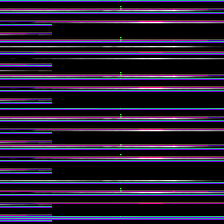

In [71]:
# rgb_uint8 = (np.dstack((norm_vabc,norm_iabc,norm_PD_SD_vabc,norm_PD_SD_iabc,norm_vabc_even_odd,norm_vabc_even_odd))*255).astype(np.uint8)
rgb_uint8 = np.stack((ch1,ch2,ch3), axis = 2).astype(np.uint8)
# rgb_uint8 = np.array(data, dtype=np.uint8)
# mat = np.reshape(rgb_uint8,(224,224,3))
img = Image.fromarray((rgb_uint8) ,mode='RGB')
img.save('test_new4.png')
img 

In [72]:
rgb_uint8.shape

(224, 224, 3)

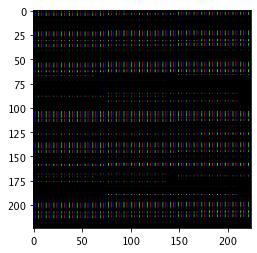

In [195]:
from keras.preprocessing import image
from PIL import Image as pil_image
img = image.load_img("test_new2.png",target_size=(224,224,3))
img = np.asarray(img)
plt.imshow(img)

In [715]:
# from PIL import Image as pil_image
img2 = Image.open('test_new4.png')
img2.load()
arr = np.asarray(img2)
# print(arr)

[[[165 118 237]
  [166 119 237]
  [166 121 239]
  ...
  [172 129 248]
  [172 130 248]
  [172 128 247]]

 [[  8  25 246]
  [  8  21 246]
  [  8  25 246]
  ...
  [  8  25 246]
  [  8  25 246]
  [  8  25 246]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 ...

 [[  8  21 246]
  [  8  21 246]
  [  8  25 246]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]


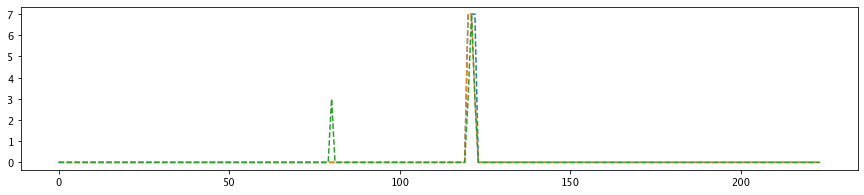

In [78]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,3))
plt.plot(rgb_uint8[5], linestyle = '--')
plt.show()

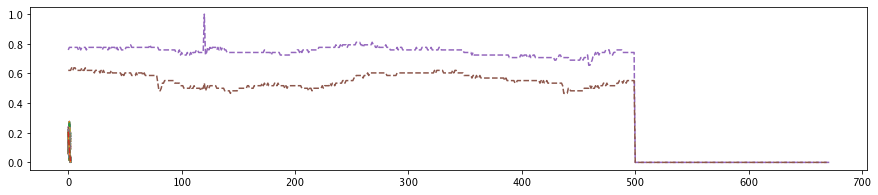

In [62]:
#normalized array plotv2
plt.figure(figsize=(15,3))
plt.plot(norm_va, linestyle = '--')
plt.plot(norm_vb, linestyle = '--')
plt.plot(norm_vc, linestyle = '--')

plt.show()

### All channel data input

In [23]:
# for i,j in new_result.items():
#     vabc_all = 

## Rough

In [165]:
# x = np.stack((layer1,layer2,layer3))
# x.shape
# x = np.zeros(224).reshape(1,224)
# # x = x.ravel()
# y = np.zeros(448).reshape(2,224)
# # y = y.ravel()
# # y.shape
# np.concatenate((x,y))


In [167]:
# ch4 = np.concatenate((layer24,layer26,layer27,layer28,layer29,layer30),axis = 0).reshape(24,224)# OTHERs

In [168]:
# p_min = pabc_min
# q_min = qabc_min
# pq_range = max(pabc_max - pabc_min, qabc_max - qabc_min)
# pq_range

# norm_pa = (_all[30] - pabc_min)/pq_range
# norm_pa

In [169]:
###### Needs to be clarified

# pqabc_all = np.dstack((_all[30],_all[31],_all[32],_all[33],_all[34],_all[35]))
# pqabc_max = np.max(pqabc_all)# separate
# pqabc_min = np.min(pqabc_all) # separate
#PA PB PC
# norm_pabc = (pabc_all-pabc_min)/(pabc_max-pabc_min)
# find the maximum P and Q,

In [ ]:
##### Needs Attention
# #for p and q  
# norm_pa = (_all[30] - pqabc_min)/(pqabc_max- pqabc_min)
# #
# norm_pb = (_all[31] - pqabc_min)/(pqabc_max- pqabc_min)
# norm_pc = (_all[32] - pqabc_min)/(pqabc_max- pqabc_min)

# norm_qa = (_all[33] - pqabc_min)/(pqabc_max- pqabc_min)
# norm_qb = (_all[34] - pqabc_min)/(pqabc_max- pqabc_min)
# norm_qc = (_all[35] - pqabc_min)/(pqabc_max- pqabc_min)

In [ ]:
# norm_va,norm_vb,norm_vc,norn_ia,norm_ib,norm_ic,norm_va_pd,norm_vb_pd,norm_vc_pd,
#     norm_va_sd,norm_vb_sd,norm_vc_sd,norm_ia_pd,norm_ib_pd,norm_ic_pd,norm_ia_sd,norm_ib_sd,norm_ic_sd,
#     norm_va_evens,norm_vb_evens,norm_vc_evens,norm_va_odds,norm_vb_odds,norm_vc_odds,
#     norm_ia_evens,norm_ib_evens,norm_ic_evens,norm_ia_odds,norm_ib_odds,norm_ic_odds,
#     norm_pa,norm_pb,norm_pc,
#     norm_qa,norm_qb,norm_qc

In [30]:
import numpy as np
a = np.array([1,2,3,4,5,6,7,8])
b = np.array([3,4,5,6,7,8,9])
c = np.array([11,22,33,44,55])
d = np.array([12,23,34,45,67])
e = np.array([13,35,57,68,40])
f = np.array([14,25,36,47,58])

In [31]:
# x = np.array([])
x=[]
x

[]

In [32]:
x.append(a)
x.append(b)
x.append(c)
x.append(d)
x.append(e)
x.append(f)
x

[array([1, 2, 3, 4, 5, 6, 7, 8]),
 array([3, 4, 5, 6, 7, 8, 9]),
 array([11, 22, 33, 44, 55]),
 array([12, 23, 34, 45, 67]),
 array([13, 35, 57, 68, 40]),
 array([14, 25, 36, 47, 58])]

In [33]:
x

[array([1, 2, 3, 4, 5, 6, 7, 8]),
 array([3, 4, 5, 6, 7, 8, 9]),
 array([11, 22, 33, 44, 55]),
 array([12, 23, 34, 45, 67]),
 array([13, 35, 57, 68, 40]),
 array([14, 25, 36, 47, 58])]

In [34]:
from enum import IntEnum
class ce(IntEnum):
    v = 0,
    i = 3,
    v_pd = 6,
    i_pd = 9,
    v_sd = 12,
    i_sd = 15,
    v_evens = 18,
    i_evens = 21,
    v_odds = 24,
    i_odds = 27,
    p = 30
    q = 33

In [35]:
Seq1 = [ce.v,ce.i,ce.v_pd,ce.i_pd,ce.v_sd,ce.i_pd,ce.v_evens,ce.i_evens,ce.v_odds,ce.i_odds,ce.p,ce.q]
Seq2 = [ce.v,ce.i,ce.v_pd,ce.i_pd,ce.v_sd,ce.i_pd,ce.v_evens,ce.i_evens,ce.v_odds,ce.i_odds,ce.p,ce.q]
Seq3 = [ce.v,ce.i,ce.v_pd,ce.i_pd,ce.v_sd,ce.i_pd,ce.v_evens,ce.i_evens,ce.v_odds,ce.i_odds,ce.p,ce.q]
Seq4 = [ce.v,ce.i,ce.v_pd,ce.i_pd,ce.v_sd,ce.i_pd,ce.v_evens,ce.i_evens,ce.v_odds,ce.i_odds,ce.p,ce.q]
Seq5 = [ce.v,ce.i,ce.v_pd,ce.i_pd,ce.v_sd,ce.i_pd,ce.v_evens,ce.i_evens,ce.v_odds,ce.i_odds,ce.p,ce.q]
Seq6 = [ce.v,ce.i,ce.v_pd,ce.i_pd,ce.v_sd,ce.i_pd,ce.v_evens,ce.i_evens,ce.v_odds,ce.i_odds,ce.p,ce.q]
# 2 channel sequence
Seq7 = [ce.v,ce.i]

seq_list = [Seq1,Seq2,Seq3,Seq4,Seq5,Seq6,Seq7]

In [36]:
x[seq_list[0][0]+3]

array([12, 23, 34, 45, 67])

In [ ]:
 # layer1 = (np.stack((final_norm[ce.v],final_norm[ce.i],final_norm[ce.v_pd],final_norm[ce.i_pd],final_norm[ce.v_sd],final_norm[ce.i_sd],final_norm[ce.v_evens],final_norm[ce.i_evens],final_norm[ce.v_odds],final_norm[ce.i_odds],final_norm[ce.p],final_norm[ce.q]), axis=1)*255).reshape(36,224)
    # layer2 = (np.stack((final_norm[1],final_norm[4],final_norm[7],final_norm[10],final_norm[13],final_norm[16],final_norm[19],final_norm[22],final_norm[25],final_norm[28],final_norm[31],final_norm[34]), axis=1)*255).reshape(36,224)
    # layer3 = (np.stack((final_norm[2],final_norm[5],final_norm[8],final_norm[11],final_norm[14],final_norm[17],final_norm[20],final_norm[23],final_norm[26],final_norm[29],final_norm[32],final_norm[35]), axis=1)*255).reshape(36,224)

    # layer4 = (np.stack((final_norm[17],final_norm[20],final_norm[23],final_norm[26],final_norm[29],final_norm[2],final_norm[5],final_norm[8],final_norm[11],final_norm[14],final_norm[32],final_norm[35]), axis=1)*255).reshape(36,224)
    # layer5 = (np.stack((final_norm[16],final_norm[19],final_norm[22],final_norm[25],final_norm[28],final_norm[1],final_norm[4],final_norm[7],final_norm[10],final_norm[13],final_norm[31],final_norm[34]), axis=1)*255).reshape(36,224)
    # layer6 = (np.stack((final_norm[15],final_norm[18],final_norm[21],final_norm[24],final_norm[27],final_norm[0],final_norm[3],final_norm[6],final_norm[9],final_norm[12],final_norm[30],final_norm[33]), axis=1)*255).reshape(36,224)

    # layer7 = (np.stack((final_norm[18],final_norm[21],final_norm[24],final_norm[27],final_norm[30],final_norm[33],final_norm[0],final_norm[3],final_norm[6],final_norm[9],final_norm[12],final_norm[15]), axis=1)*255).reshape(36,224)
    # layer8 = (np.stack((final_norm[19],final_norm[22],final_norm[25],final_norm[28],final_norm[31],final_norm[34],final_norm[1],final_norm[4],final_norm[7],final_norm[10],final_norm[13],final_norm[16]), axis=1)*255).reshape(36,224)
    # layer9 = (np.stack((final_norm[20],final_norm[23],final_norm[26],final_norm[29],final_norm[32],final_norm[35],final_norm[2],final_norm[5],final_norm[8],final_norm[11],final_norm[14],final_norm[17]), axis=1)*255).reshape(36,224)

    # layer10 = (np.stack((final_norm[2],final_norm[5],final_norm[8],final_norm[11],final_norm[14],final_norm[17],final_norm[20],final_norm[23],final_norm[26],final_norm[29],final_norm[32],final_norm[35]), axis=1)*255).reshape(36,224)
    # layer11 = (np.stack((final_norm[1],final_norm[4],final_norm[7],final_norm[10],final_norm[13],final_norm[16],final_norm[19],final_norm[22],final_norm[25],final_norm[28],final_norm[31],final_norm[34]), axis=1)*255).reshape(36,224)
    # layer12 = (np.stack((final_norm[0],final_norm[3],final_norm[6],final_norm[9],final_norm[12],final_norm[15],final_norm[18],final_norm[21],final_norm[24],final_norm[27],final_norm[30],final_norm[33]), axis=1)*255).reshape(36,224)

    # layer13 = (np.stack((final_norm[24],final_norm[27],final_norm[30],final_norm[33],final_norm[0],final_norm[3],final_norm[6],final_norm[9],final_norm[12],final_norm[15],final_norm[18],final_norm[21]), axis=1)*255).reshape(36,224)
    # layer14 = (np.stack((final_norm[25],final_norm[28],final_norm[31],final_norm[34],final_norm[1],final_norm[4],final_norm[7],final_norm[10],final_norm[13],final_norm[16],final_norm[19],final_norm[22]), axis=1)*255).reshape(36,224)
    # layer15 = (np.stack((final_norm[26],final_norm[29],final_norm[32],final_norm[35],final_norm[2],final_norm[5],final_norm[8],final_norm[11],final_norm[14],final_norm[17],final_norm[20],final_norm[23]), axis=1)*255).reshape(36,224)

    # layer16 = (np.stack((final_norm[32],final_norm[35],final_norm[2],final_norm[5],final_norm[8],final_norm[11],final_norm[14],final_norm[17],final_norm[20],final_norm[23],final_norm[26],final_norm[29]), axis=1)*255).reshape(36,224)
    # layer17 = (np.stack((final_norm[31],final_norm[34],final_norm[1],final_norm[4],final_norm[7],final_norm[10],final_norm[13],final_norm[16],final_norm[19],final_norm[22],final_norm[25],final_norm[28]), axis=1)*255).reshape(36,224)
    # layer18 = (np.stack((final_norm[30],final_norm[33],final_norm[0],final_norm[3],final_norm[6],final_norm[9],final_norm[12],final_norm[15],final_norm[18],final_norm[21],final_norm[24],final_norm[27]), axis=1)*255).reshape(36,224)

    # # 2channels VA
    # layer24 = (np.stack((final_norm[0],final_norm[3]), axis=1)*255).reshape(6,224)
    # #zero 448(2x224)
    # layer26 = np.zeros(448).reshape(2,224)
    # # layer27 = np.zeros(224).reshape(1,224)

    # # 2chanel VB
    # layer27 = (np.stack((final_norm[1],final_norm[4]), axis=1)*255).reshape(6,224)
    # #zero 448(2x224)
    # layer28 = np.zeros(448).reshape(2,224)
    # # layer27 = np.zeros(224).reshape(1,224)

    # # 2 Channel VC
    # layer29 = (np.stack((final_norm[2],final_norm[5]), axis=1)*255).reshape(6,224)
    # #zero 448(2x224)
    # layer30 = np.zeros(448).reshape(2,224)
